# EDA + Entrenamiento de modelo de referencia ResNet50 + Prueba

### Alumno : Gustavo Ayrton Bitocchi
### Director : Diego Alexis Evin
### Universidad Austral Cohorte 2020/21
### Trabajo final de Maestria
------------------------------------------------------------------------------------------------------

#### El siguiente notebook fue ejecutado utilizando una instancia ml.p3.2xlarge en AWS SageMaker y, previamente, guardando el conjunto de datos en un Bucket S3.

## Bibliotecas

In [ ]:
# Instalacion de bibliotecas

pip install cloudpathlib

In [ ]:
# Importamos bibliotecas
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
import torchvision.models as models

from matplotlib.image import imread
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, roc_auc_score
from cloudpathlib import CloudPath 

%matplotlib inline 

## Descarga de conjuntos de datos

In [ ]:
# Descargamos conjunto de entrenamiento de bucket S3

cp = CloudPath("s3://xray-tesis-austral-bucket/Conjunto de datos/Entrenamiento/")
cp.download_to("Entrenamiento")

# Descargamos conjunto de prueba de bucket S3

cp = CloudPath("s3://xray-tesis-austral-bucket/Conjunto de datos/Prueba/")
cp.download_to("Prueba")

In [ ]:
# Definimos directorios donde se encuentran conjuntos de datos de entrenamiento y prueba

training_dataset_dir = "/Entrenamiento"
testing_dataset_dir = "/Prueba"

## Analisis estadistico descriptivo (EDA)

In [ ]:
# Visualizamos cantidad de ejemplos de neumonia para entrenar

pneumonia_files = os.listdir(training_dataset_dir + "/Neumonia")
print('Cantidad de ejemplos de neumonia para entrenar:', len(pneumonia_files))
print(pneumonia_files[:5])

Cantidad de ejemplos de neumonia para entrenar: 3901
['person544_virus_1075.jpeg', 'person595_virus_1147.jpeg', 'person600_virus_1156.jpeg', 'person552_bacteria_2313.jpeg', 'person543_bacteria_2282.jpeg']


In [ ]:
# Cargamos dataset de entrenamiento aplicando varias transformaciones para evitar el sobreajuste

training_dataset = ImageFolder(training_dataset_dir, 
                               transform=tt.Compose([tt.Resize(255),
                                                     tt.CenterCrop(224),
                                                     tt.RandomHorizontalFlip(),
                                                     tt.RandomRotation(10),
                                                     tt.RandomGrayscale(),
                                                     tt.RandomAffine(translate=(0.05,0.05), degrees=0),
                                                     tt.ToTensor()]))

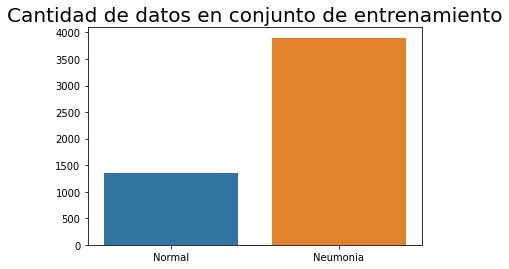

In [ ]:
# Visualizamos histograma de cantidad de datos en conjunto de entrenamiento para ambas clases

train_samplesize = pd.DataFrame.from_dict({
    'Normal': [len([os.path.join(training_dataset_dir + '/Normal', filename) for filename in os.listdir(training_dataset_dir + '/Normal')])], 
    'Neumonia': [len([os.path.join(training_dataset_dir + '/Neumonia', filename) for filename in os.listdir(training_dataset_dir + '/Neumonia')])]
     })

sns.barplot(data=train_samplesize).set_title('Cantidad de datos en conjunto de entrenamiento', fontsize=20)
plt.show()

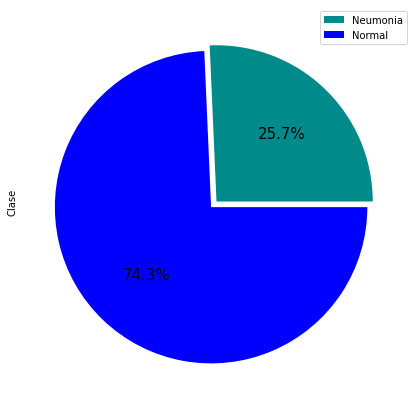

In [ ]:
# Visualizamos grafico de torta que nos indica porcentualmente que hay mayor cantidad de pruebas normales que neumonia (Alto desbalanceo de clases)

train_saimplesize_transposed = train_samplesize.transpose()
train_saimplesize_transposed = train_saimplesize_transposed.rename(columns={0: 'Clase'})

plt.figure(figsize=(7,10))
train_saimplesize_transposed['Clase'].plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})
plt.legend(labels=['Neumonia', 'Normal'])
plt.show()

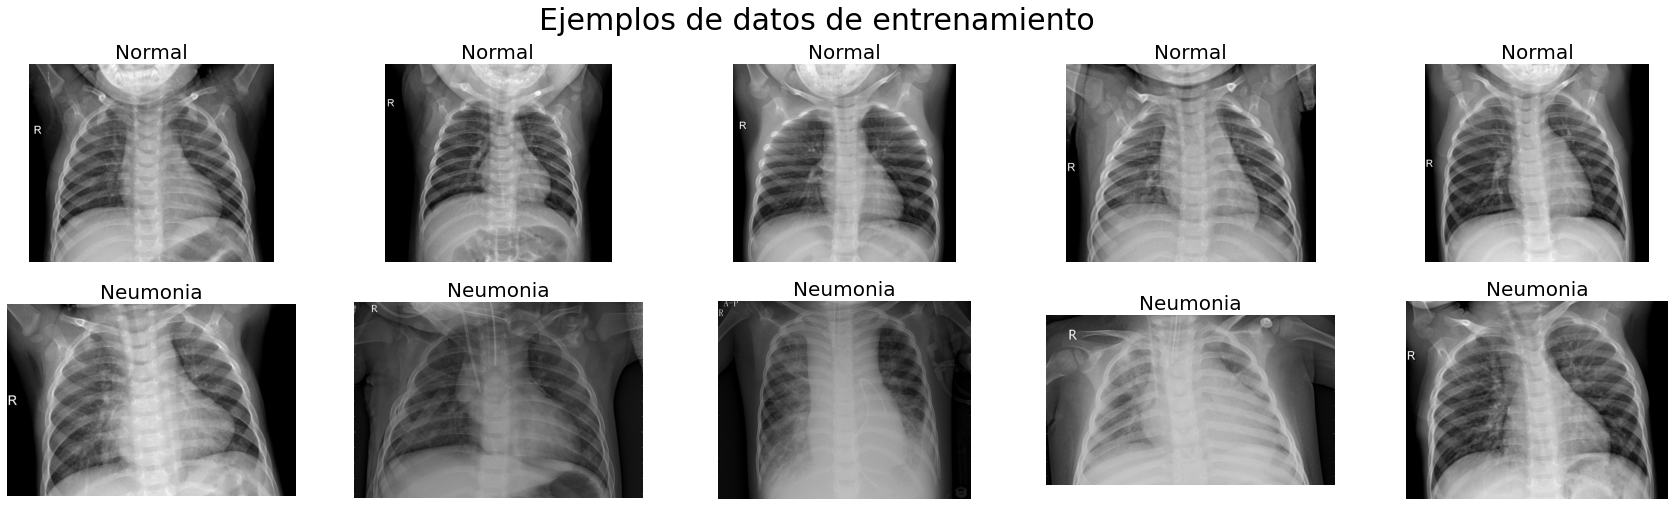

In [ ]:
# Definimos funcion que grafica muestras de examenes

def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,8))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("Normal", fontsize=20)
        else:
            ax[i//5][i%5].set_title("Neumonia", fontsize=20)
        ax[i//5][i%5].axis('off')

rand_samples = random.sample([os.path.join(training_dataset_dir + '/Normal', filename) for filename in os.listdir(training_dataset_dir + '/Normal')], 5) + \
    random.sample([os.path.join(training_dataset_dir + '/Neumonia', filename) for filename in os.listdir(training_dataset_dir + '/Neumonia')], 5)

plot_samples(rand_samples)
plt.suptitle('Ejemplos de datos de entrenamiento', fontsize=30)
plt.show()

## Creacion de conjunto de entrenamiento y validacion

In [ ]:
# Definimos semilla para repeticion de resultados

random_seed = 2020
torch.manual_seed(random_seed);

In [ ]:
# Dividimos conjunto de entrenamiento en un 70% entrenamiento y el resto validacion

train_size = round(len(training_dataset)*0.7)
val_size = len(training_dataset) - train_size

training_set, validation_set = random_split(training_dataset, [train_size, val_size])
len(training_set), len(validation_set)

(3675, 1575)

In [ ]:
# Creamos dataloader para conjunto de entrenamiento y validacion

batch_size = 100

training_dataloader = DataLoader(training_set, batch_size, shuffle=True, pin_memory=True, num_workers=4)
validation_dataloader = DataLoader(validation_set, batch_size, shuffle=True, pin_memory=True, num_workers=4)

## Definicion de funciones de manejo de datos en GPU

In [ ]:
# Definimos funcion que elige si esta diponible la GPU, caso contrario elige CPU

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()

In [ ]:
# Definimos funcion que mueve una variable al dispositivo disponible (GPU o CPU)

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
# Creamos un dataloader para el dispotivo y el manejo facil del paso de informacion entre GPU y CPU

class DeviceDataLoader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        for data in self.dataloader: 
            yield to_device(data, self.device)

    def __len__(self):
        return len(self.dataloader)

## Definicion de funciones y clases para entrenamiento de modelo

In [ ]:
# Creamos funcion que calcula el roc-auc-score de las salidas de la ResNet50

def auc_score(outputs, labels):
    _, preds = torch.max(outputs, dim=1)

    labels = labels.cpu()
    preds = preds.cpu()

    return torch.tensor(roc_auc_score(labels, preds)), preds

In [ ]:
# Creamos modelo base que manejara el proceso de entrenamiento de la CNN

class PneumoniaModelBase(nn.Module):
    def training_step(self, batch, weight):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels, weight=weight)
        auc_roc, preds = auc_score(out, labels)
        
        return {'train_loss': loss, 'train_auc_roc': auc_roc}
       
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_auc_rocs = [x['train_auc_roc'] for x in outputs]
        epoch_auc_roc = torch.stack(batch_auc_rocs).mean()
        
        return {'train_loss': epoch_loss.item(), 'train_auc_roc': epoch_auc_roc.item()}
    
    def validation_step(self, batch):
        images,labels = batch
        out = self(images) 
        loss = F.cross_entropy(out, labels)
        auc_roc, preds = auc_score(out, labels)
        
        return {'val_loss': loss.detach(), 'val_auc_roc': auc_roc.detach(), 'preds': preds.detach(), 'labels': labels.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs] 
        epoch_loss = torch.stack(batch_losses).mean()  
        batch_auc_rocs = [x['val_auc_roc'] for x in outputs]
        epoch_auc_roc = torch.stack(batch_auc_rocs).mean()
        
        return {'val_loss': epoch_loss.item(), 'val_auc_roc': epoch_auc_roc.item()}

    def epoch_end(self, epoch, train_result, val_result):
        print('Epoch [{}], train_loss: {:.4f}, train_auc_roc: {:.4f}, val_loss: {:.4f}, val_auc_roc: {:.4f}'.
              format(epoch+1, train_result['train_loss'], train_result['train_auc_roc'], 
                     val_result['val_loss'], val_result['val_auc_roc']))
    
    def test_prediction(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_auc_rocs = [x['val_auc_roc'] for x in outputs]
        epoch_auc_roc = torch.stack(batch_auc_rocs).mean()
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_auc_roc': epoch_auc_roc.item(), 'test_preds': batch_preds, 'test_labels': batch_labels}      

In [ ]:
# Creamos modelo benchmark ResNet50 sin pre-entrenar (transfer learning) para la correcta comparacion respecto al modelo CNN autogenerado

resnet50 = models.resnet50(pretrained=False)

In [ ]:
# Creamos una clase que nos permitira adaptar el modelo ResNet50 cargado con nuestro modelo base para el entrenamiento, definiendo 2 salidas en la ultima capa (normal y neumonia)

class PneumoniaResnet(PneumoniaModelBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet50(pretrained=False)
        num_features = self.network.fc.in_features
        self.network.fc = nn.Linear(num_features, 2)
    
    def forward(self, xb):
        return self.network(xb)

In [ ]:
# Definimos funcion que evalua el modelo en el conjunto de validacion

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# Definimos funcion que empieza el entrenamiento del modelo y permite ajustar a los datos ingresados

def fit(epochs, lr, model, train_loader, val_loader, weight, opt_func):
    torch.cuda.empty_cache() # Liberamos memoria cache
    history = {}
    optimizer = opt_func(model.parameters(), lr)
    best_loss = 1

    for epoch in range(epochs):
        model.train() 
        train_outputs = []      
        lrs = []

        for batch in train_loader:
            outputs = model.training_step(batch, weight)
            loss = outputs['train_loss']
            train_outputs.append(outputs)
            train_results = model.train_epoch_end(train_outputs)                        
            loss.backward()
            optimizer.step()                                
            optimizer.zero_grad()  
                                         
        val_results = evaluate(model, val_loader)

        if val_results['val_loss'] < best_loss:
            best_loss = min(best_loss, val_results['val_loss'])
            best_model_wts = copy.deepcopy(model.state_dict())
        
        model.epoch_end(epoch, train_results, val_results)
        to_add = {'train_loss': train_results['train_loss'],
                  'train_auc_roc': train_results['train_auc_roc'],
                  'val_loss': val_results['val_loss'],
                  'val_auc_roc': val_results['val_auc_roc'], 
                  'lrs': lrs}
        
        for key,val in to_add.items():
            if key in history:
                history[key].append(val)
            else:
                history[key] = [val]
    
    model.load_state_dict(best_model_wts)    
    return history, optimizer, best_loss

## Entrenamiento del modelo

In [ ]:
# Movemos modelo, conjunto de entrenamiento y prueba al dispositivo disponible (GPU en nuestro caso)

training_dataloader = DeviceDataLoader(training_dataloader, device)
validation_dataloader = DeviceDataLoader(validation_dataloader, device)
model = to_device(PneumoniaResnet(), device)

In [ ]:
epochs = 20 # Cantidad de epocas a entrenar
lr = 0.0001 # Tasa de aprendizaje
opt_func = torch.optim.Adam # Optimizador Adam con β_1=0.9, β_2=0.999, ε=1.0 x 10^(-8)
weight = torch.FloatTensor([3901/(1349+3901), 1349/(1349+3901)]).to(device) # Criterio que nos permitira evaluar el rendimiento del modelo (Aplicando pesos por las clases desbalanceadas)

In [ ]:
# Empezamos entrenamiento del modelo
training_start_time = time.time()
history, optimizer, best_loss = fit(epochs, lr, model, training_dataloader, validation_dataloader, weight, opt_func)
training_end_time = time.time()

In [ ]:
# Obtenemos tiempo de entrenamiento
print("Tiempo de entrenamiento en segundos:", end - start)

In [ ]:
# Obtenemos la mejor perdida

print('Mejor loss es:', best_loss)

In [ ]:
# Guardamos mejor modelo generado

bestmodel = {'model': PneumoniaResnet(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(bestmodel, 'Resnet50_Benchmark.pth')

In [ ]:
# Visualizamos mediante series el rendimiento del modelo en el entrenamiento/validacion a medida que aumentan las epocas

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Rendimiento', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history['train_auc_roc'], label='Entrenamiento AUC-ROC')
ax1.plot(epoch_list, history['val_auc_roc'], label='Validacion AUC-ROC')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Valor AUC-ROC')
ax1.set_xlabel('Epoca')
ax1.set_title('AUC-ROC')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history['train_loss'], label='Entrenamiento Loss')
ax2.plot(epoch_list, history['val_loss'], label='Validacion Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoca')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

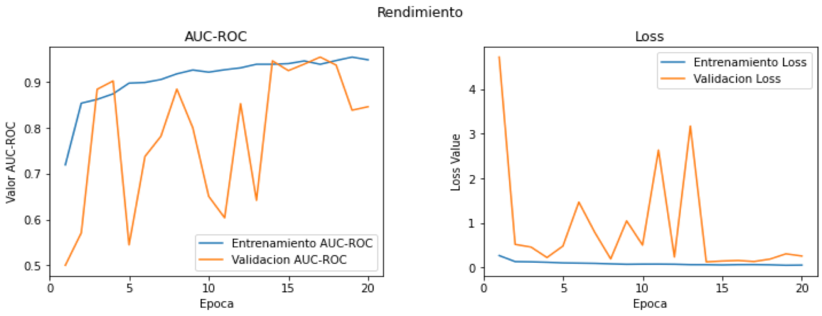

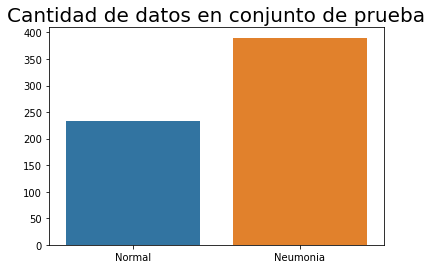

In [ ]:
# Visualizamos histograma de cantidad de datos en conjunto de prueba para ambas clases

test_samplesize = pd.DataFrame.from_dict({
    'Normal': [len([os.path.join(data_dir+'/Prueba/Normal', filename) for filename in os.listdir(data_dir+'/Prueba/Normal')])], 
    'Neumonia': [len([os.path.join(data_dir+'/Prueba/Neumonia', filename) for filename in os.listdir(data_dir+'/Prueba/Neumonia')])]})

sns.barplot(data=test_samplesize).set_title('Cantidad de datos en conjunto de prueba', fontsize=20)
plt.show()

## Estimacion en conjunto de prueba + Metricas

In [ ]:
# Definimos funcion que nos permitira estimar el conjunto de prueba

@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    model.cuda()
    outputs = [model.validation_step(batch) for batch in test_loader] 
    results = model.test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'.format(results['test_loss'], results['test_auc_roc']))
    
    return results['test_preds'], results['test_labels']

In [ ]:
# Cargamos dataset de prueba aplicando varias transformaciones para evitar el sobreajuste (y adecuandonos al conjunto de entrenamiento para evitar inconsistencias)

test_dataset = ImageFolder(testing_dataset_dir, 
                           transform=tt.Compose([tt.Resize(255),
                                                 tt.CenterCrop(224),                                                              
                                                 tt.ToTensor()
                                                ]))

In [ ]:
# Cargamos conjunto de prueba y modelo en GPU

test_dataloader = DataLoader(test_dataset, batch_size = 256, shuffle = True)
test_dataloader = DeviceDataLoader(test_dataloader, device)
model.cuda()

In [ ]:
# Realizamos estimacion del modelo sobre el conjunto de prueba

preds, labels = test_predict(model, test_dataloader)

test_loss: 0.5238, test_acc: 0.8226


<Figure size 432x288 with 0 Axes>

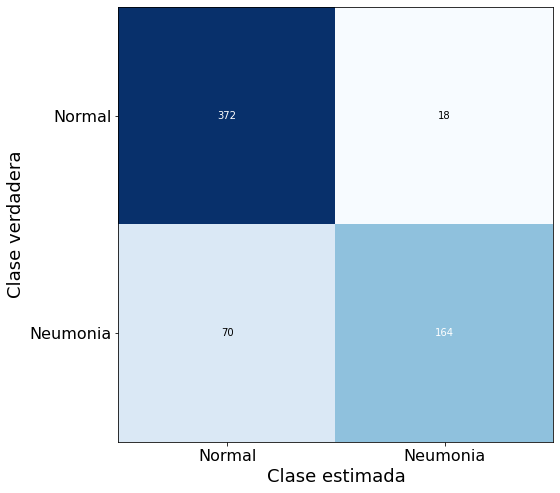

In [ ]:
# Generamos matriz de confusion para los resultados de pruebaa

cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Neumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Neumonia'], fontsize=16)
plt.xlabel('Clase estimada',fontsize=18)
plt.ylabel('Clase verdadera',fontsize=18)
plt.show()

In [ ]:
# Obtenemos metricas de exactitud, recall, precision, F1-Score y AUC-ROC con respecto a las estimaciones obtenidas en el conjunto de prueba

tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))
auc_roc = roc_auc_score(labels, preds)

print("La exactitud del modelo es {:.2f}".format(accuracy))
print("El Recall del modelo es {:.2f}".format(recall))
print("La precision del modelo es {:.2f}".format(precision))
print("El F1-Score del modelo es {:.2f}".format(f1))
print("El AUC-ROC Score del modelo es {:.2f}".format(auc_roc))

La exactitud del modelo es 0.86
El Recall del modelo es 0.70
La precision del modelo es 0.90
El F1 Score del modelo es 0.79
El AUC-ROC Score del modelo es 0.83


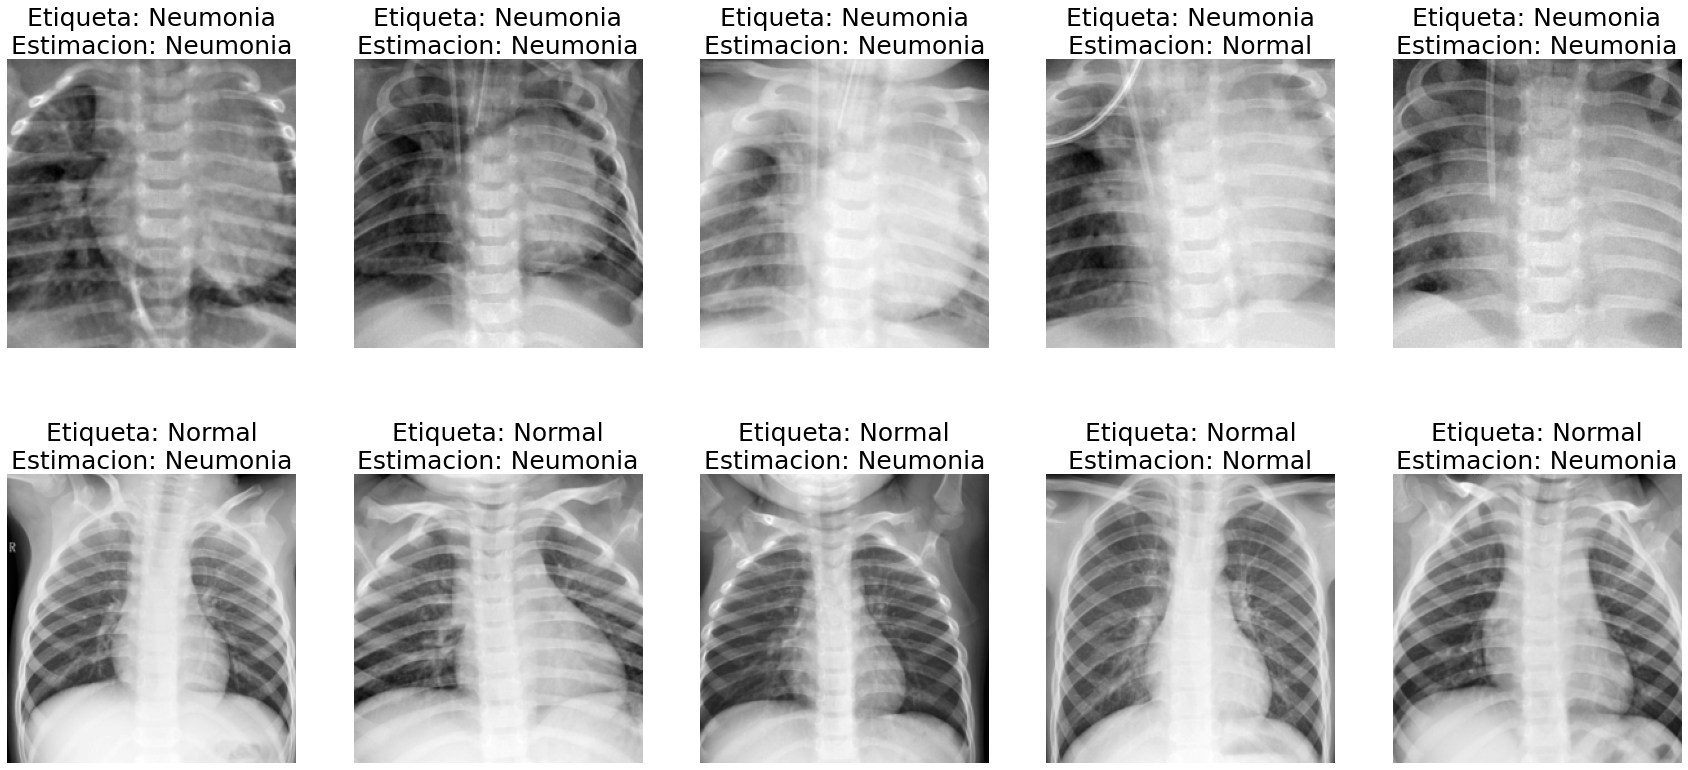

In [ ]:
# Ejemplos de estimacion del modelo versus etiqueta verdadera en el conjunto de prueba

idxs = torch.tensor(np.append(np.arange(start=0, stop=5, step=1), 
                             np.arange(start=500, stop=505, step=1))) 

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,14))

for c,i in enumerate(idxs):
    img_tensor, label = test_dataset[i]
    ax[c//5][c%5].imshow(img_tensor[0,:,:], cmap='gray')
    ax[c//5][c%5].set_title('Etiqueta: {}\nEstimacion: {}'
                            .format(test_dataset.classes[label], 
                                    test_dataset.classes[preds[i]]),
                            fontsize=25)
    ax[c//5][c%5].axis('off')